In [72]:
'''
安贤量化project
用2020-1-2 to 2020-6-30预测接下来五个交易日的交易量
@author: Yuan Ji
'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline
CSV_FILE_PATH = 'D:\Quant Project\AxiomQuant Data Project Exercise\data.csv'
data = pd.read_csv(CSV_FILE_PATH)
#print(data.head(10))
#print(data.tail(10))
#check basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112440 entries, 0 to 112439
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Date       112440 non-null  int64 
 1   Time       112440 non-null  object
 2   Id         112440 non-null  int64 
 3   NumTrades  112440 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.4+ MB


总结：该notebook主要对2020-01-02:2020-07-01的分钟粒度数据做了汇总和绘图，分析了自相关性（ACF）， 尝试用AR和ARMA拟合预测

如果用datetime作为index, 由于交易时间存在gap，需要对无交易的时刻补充数据（fillna = 0），会导致预测值不可靠

所以在该notebook里不用datetime作为index,直接用自然数(0,1,2,3,...28109)来标注index

预测五个交易日：5*4*60 = 1200min， 28109+1200 = 29309

所以预测到total_min = 30000

从预测结果看反应了均值， 还不能对日内交易的变化做很好的预测

-----------------------------------------------------------------
ARMA(p,q)阶数问题

在本notebook中手动尝试了p,q<5的各种组合，发现对预测结果趋势影响不大

进一步改进：根据AIC和BIC最小信息准则优化p,q数值

__________________________________________________________________
训练量问题：

在AR和ARMA模型中，如果只使用10天的交易数据（2400min）,反而会给出未来10天较为合理的预测

这其中的道理是因为平稳序列的相关性在lags>1之后迅速下降，特别大的训练数据有时反而不能给出很好的描述。

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [78]:
#prediction based on data of six months
stock_1 = data[data["Id"] == 1]
stock_2 = data[data["Id"] == 2]
stock_3 = data[data["Id"] == 3]
stock_4 = data[data["Id"] == 4]
stock_1.index = stock_1.index//4
stock_2.index = stock_2.index//4
stock_3.index = stock_3.index//4
stock_4.index = stock_4.index//4

In [79]:
stock_2

,Date,Time,Id,NumTrades
0,20200102,09:31:00.000,2,28
1,20200102,09:32:00.000,2,24
2,20200102,09:33:00.000,2,5
3,20200102,09:34:00.000,2,24
4,20200102,09:35:00.000,2,9
...,...,...,...,...
28105,20200701,09:56:00.000,2,2
28106,20200701,09:57:00.000,2,3
28107,20200701,09:58:00.000,2,0
28108,20200701,09:59:00.000,2,0


从每日交易量上来看,stock 1,2,3在去除一些特变大的交易日后总体比较均匀：可以用所有数据来预测

而stock 4在五月交易量大量上升，明显发生了变化：在选择训练数据范围时要注意尝试只用五月以后的数据

注意，由于index选择了连续整数而非datetime,周末和节日的gap消失了

<Figure size 1440x1440 with 0 Axes>

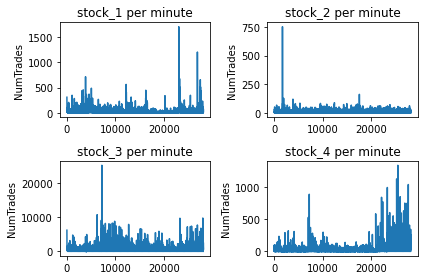

In [80]:
# Now let's plot the volume of stock being traded each minute; high freq
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.figure()
stocks = [stock_1, stock_2, stock_3, stock_4]
for i in range(1,5):
    plt.subplot(2, 2, i)
    stocks[i-1]["NumTrades"].plot(y = "NumTrades")
    plt.ylabel("NumTrades")
    plt.title("stock_"+str(i)+" per minute")
plt.tight_layout()
plt.show()

#data with no gap


观察ACF图像，发现其存在明显周期；T = 240min = 4h

非平稳时间序列，需要进行差分

每天开市有大量资金的进出，可能是机构交易的行为，故其自相关系数较大

而每天开市时间就是4h:9：30-11：30, 13:00-15:00 

需要对数据进行差分去除由开市和闭市导致的随机性： Data[t] - Data[t-1]

C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
C:\Users\Yuan Ji\AppData\Local\

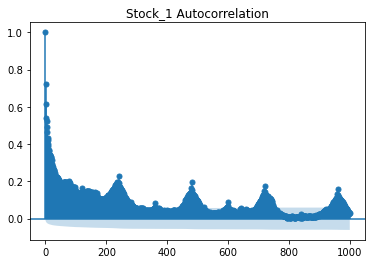

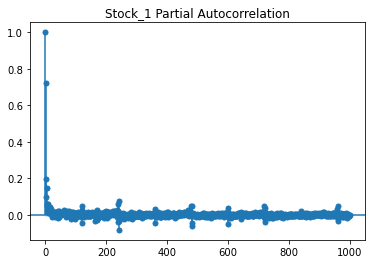

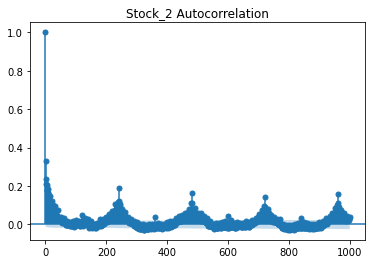

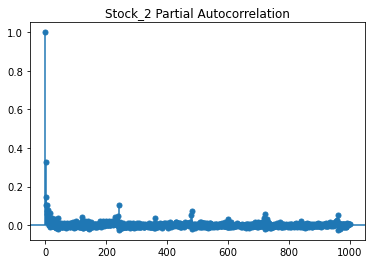

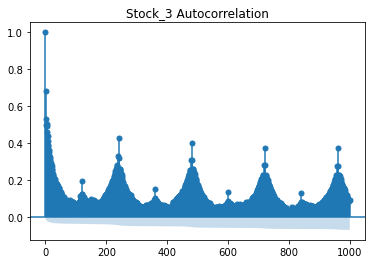

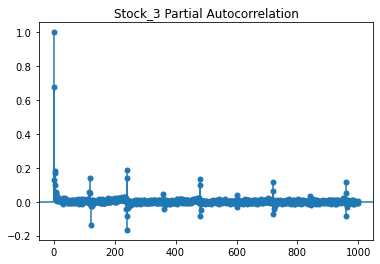

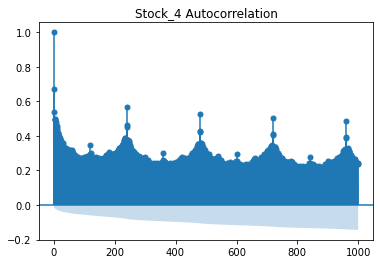

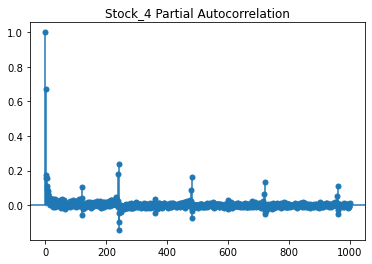

In [81]:
#statsmodel里有绘制acf和pacf图的命令 很方便
#lags定义了延迟时间
lags = [i for i in range(1000)]

plot_acf(stock_1["NumTrades"], lags = lags, title = "Stock_1 Autocorrelation").show()
plot_pacf(stock_1["NumTrades"], lags = lags, title = "Stock_1 Partial Autocorrelation").show()

plot_acf(stock_2["NumTrades"], lags = lags, title = "Stock_2 Autocorrelation").show()
plot_pacf(stock_2["NumTrades"], lags = lags, title = "Stock_2 Partial Autocorrelation").show()

plot_acf(stock_3["NumTrades"], lags = lags, title = "Stock_3 Autocorrelation").show()
plot_pacf(stock_3["NumTrades"], lags = lags, title = "Stock_3 Partial Autocorrelation").show()

plot_acf(stock_4["NumTrades"], lags = lags, title = "Stock_4 Autocorrelation").show()
plot_pacf(stock_4["NumTrades"], lags = lags, title = "Stock_4 Partial Autocorrelation").show()  

In [82]:
#数据平滑
#数据差分--》成为稳定序列
stock_1["diff"] = stock_1["NumTrades"].diff(periods = 1)
stock_2["diff"] = stock_2["NumTrades"].diff(periods = 1)
stock_3["diff"] = stock_3["NumTrades"].diff(periods = 1)
stock_4["diff"] = stock_4["NumTrades"].diff(periods = 1)


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:

In [83]:
stock_1.dropna(how = 'any', inplace = True)
stock_2.dropna(how = 'any', inplace = True)
stock_3.dropna(how = 'any', inplace = True)
stock_4.dropna(how = 'any', inplace = True)

C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [84]:
stock_1.head(10)

,Date,Time,Id,NumTrades,diff
1,20200102,09:32:00.000,1,232,-78.0
2,20200102,09:33:00.000,1,152,-80.0
3,20200102,09:34:00.000,1,172,20.0
4,20200102,09:35:00.000,1,111,-61.0
5,20200102,09:36:00.000,1,99,-12.0
6,20200102,09:37:00.000,1,89,-10.0
7,20200102,09:38:00.000,1,122,33.0
8,20200102,09:39:00.000,1,154,32.0
9,20200102,09:40:00.000,1,111,-43.0
10,20200102,09:41:00.000,1,124,13.0


<Figure size 1080x1080 with 0 Axes>

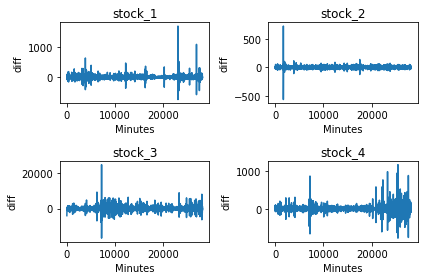

In [85]:
# Now let's plot the first-order diff
plt.figure(figsize=(15, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.figure()
stocks = [stock_1, stock_2, stock_3, stock_4]
for i in range(1,5):
    plt.subplot(2, 2, i)
    stocks[i-1]["diff"].plot(y = "diff")
    plt.xlabel("Minutes")
    plt.ylabel("diff")
    plt.title("stock_"+str(i))
plt.tight_layout()
plt.show()
#average of first-order diff is 0

可以看到差分过后ACF和PACF总体从1迅速下降，周期性消失了，意味着时间序列平稳

C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
C:\Users\Yuan Ji\AppData\Local\

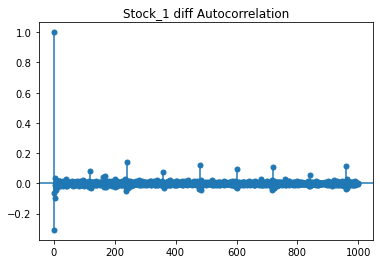

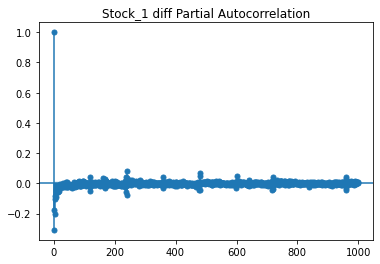

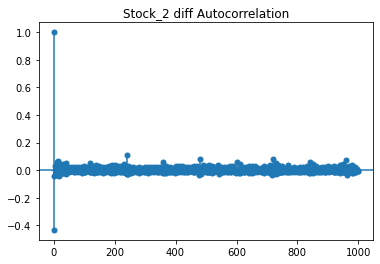

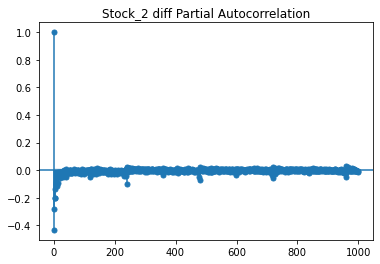

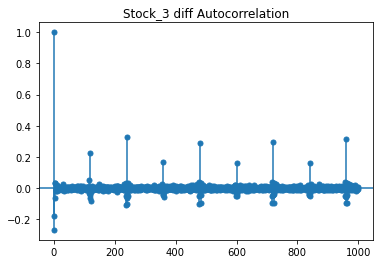

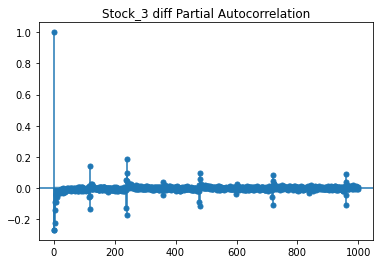

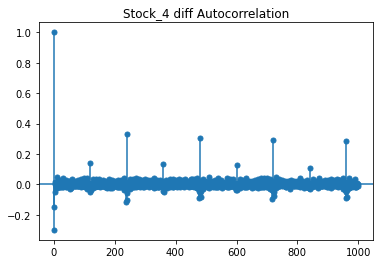

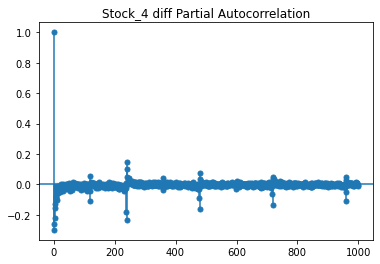

In [86]:
#statsmodel里有绘制acf和pacf图的命令 很方便
#lags定义了延迟时间
lags = [i for i in range(1000)]

plot_acf(stock_1["diff"], lags = lags, title = "Stock_1 diff Autocorrelation").show()
plot_pacf(stock_1["diff"], lags = lags, title = "Stock_1 diff Partial Autocorrelation").show()

plot_acf(stock_2["diff"], lags = lags, title = "Stock_2 diff Autocorrelation").show()
plot_pacf(stock_2["diff"], lags = lags, title = "Stock_2 diff Partial Autocorrelation").show()

plot_acf(stock_3["diff"], lags = lags, title = "Stock_3 diff Autocorrelation").show()
plot_pacf(stock_3["diff"], lags = lags, title = "Stock_3 diff Partial Autocorrelation").show()

plot_acf(stock_4["diff"], lags = lags, title = "Stock_4 diff Autocorrelation").show()
plot_pacf(stock_4["diff"], lags = lags, title = "Stock_4 diff Partial Autocorrelation").show() 

再看一下lags = 40小尺度的ACF和PACF，平稳

C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, wh

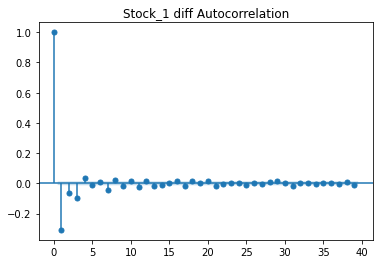

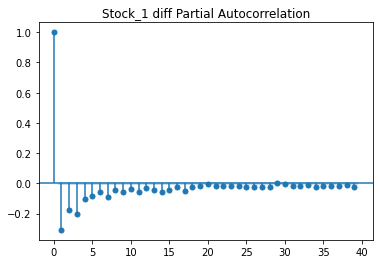

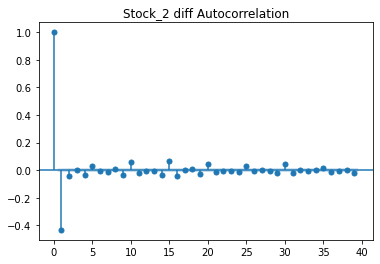

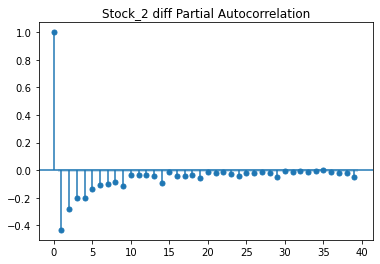

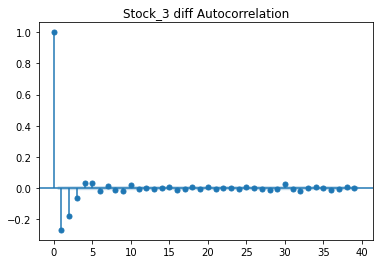

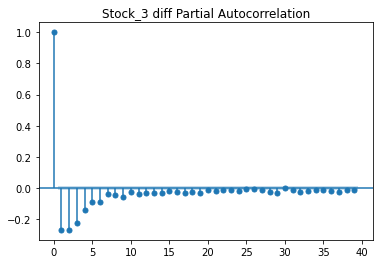

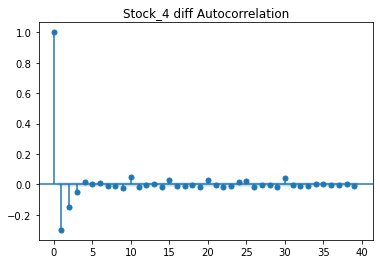

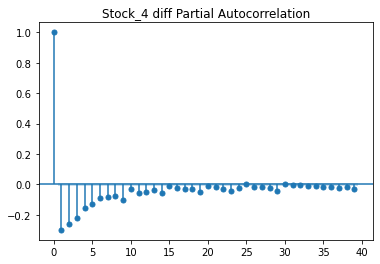

In [87]:
lags = [i for i in range(40)]

plot_acf(stock_1["diff"], lags = lags, title = "Stock_1 diff Autocorrelation").show()
plot_pacf(stock_1["diff"], lags = lags, title = "Stock_1 diff Partial Autocorrelation").show()

plot_acf(stock_2["diff"], lags = lags, title = "Stock_2 diff Autocorrelation").show()
plot_pacf(stock_2["diff"], lags = lags, title = "Stock_2 diff Partial Autocorrelation").show()

plot_acf(stock_3["diff"], lags = lags, title = "Stock_3 diff Autocorrelation").show()
plot_pacf(stock_3["diff"], lags = lags, title = "Stock_3 diff Partial Autocorrelation").show()

plot_acf(stock_4["diff"], lags = lags, title = "Stock_4 diff Autocorrelation").show()
plot_pacf(stock_4["diff"], lags = lags, title = "Stock_4 diff Partial Autocorrelation").show() 

#绘制基本信息

可以看到一阶差分后，均值为0，ACF和PACF迅速下降，表现出稳定序列的特征

In [88]:
#timeseries plot
def tsplot(y, lags=None, title='', figsize=(14, 8)):
     
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
     
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=100)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<AxesSubplot:title={'center':'Stock-1'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

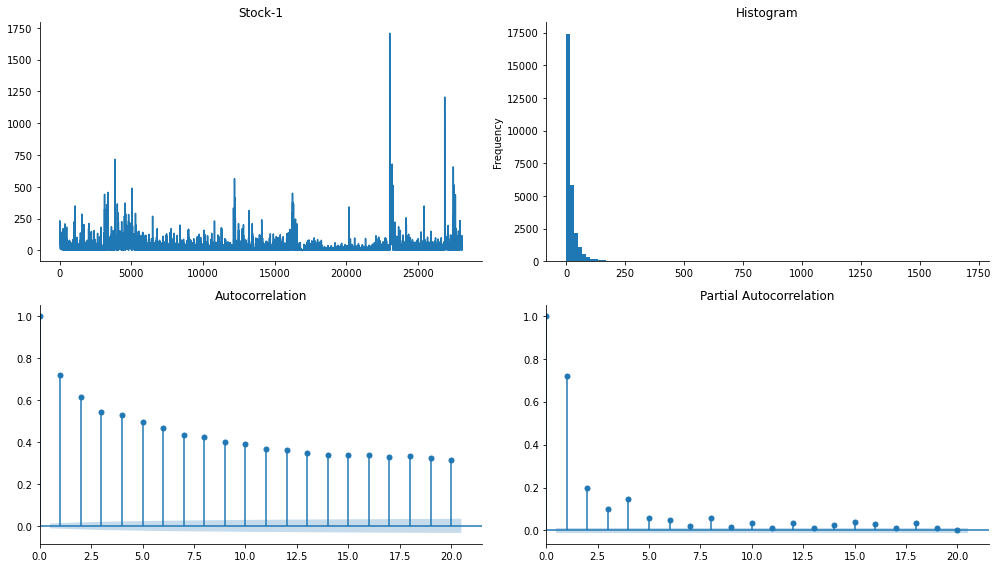

In [89]:
tsplot(stock_1["NumTrades"], title='Stock-1', lags=20)

(<AxesSubplot:title={'center':'Stock-1 diff'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

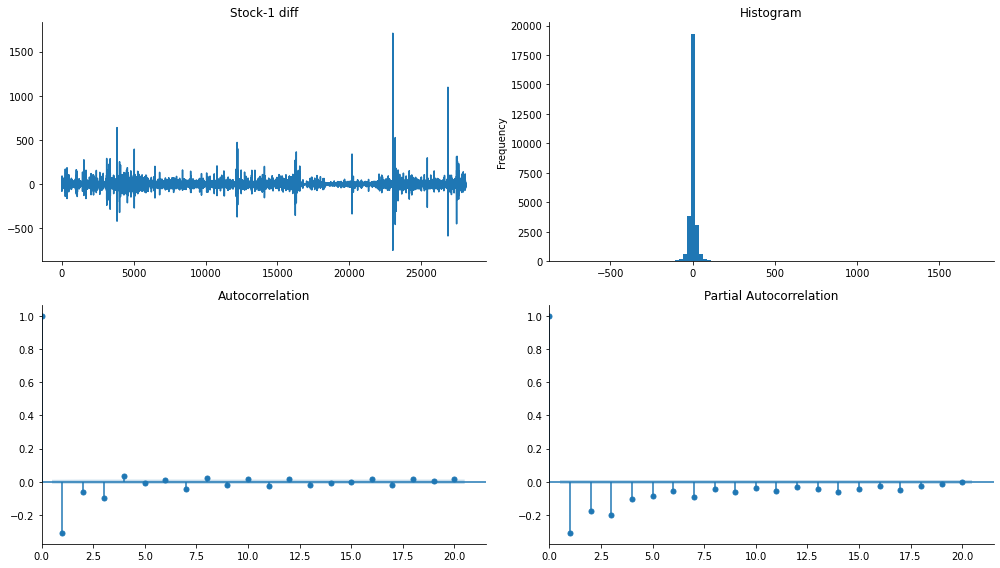

In [90]:
tsplot(stock_1["diff"], title='Stock-1 diff', lags=20)

(<AxesSubplot:title={'center':'Stock-2'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

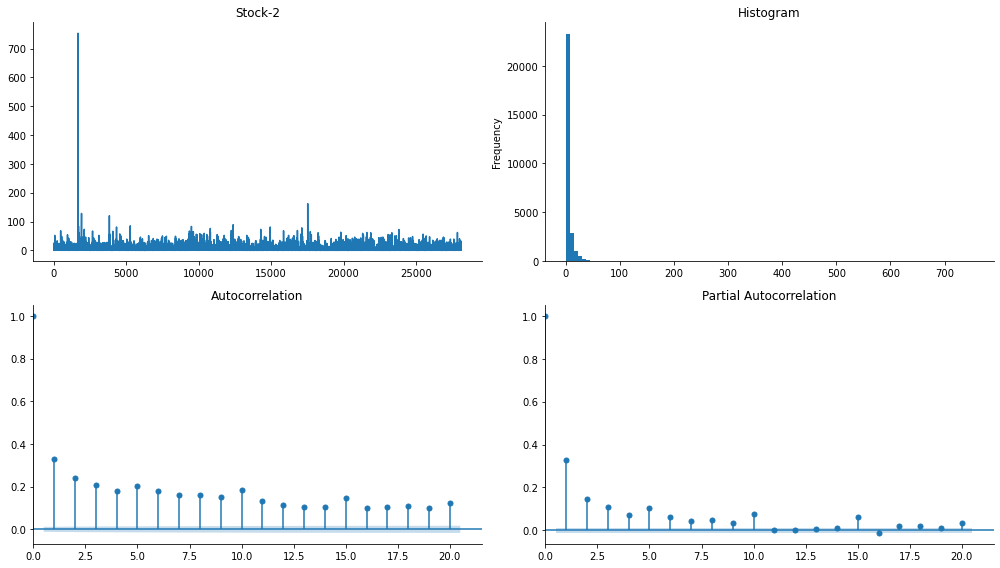

In [91]:
tsplot(stock_2["NumTrades"], title='Stock-2', lags=20)

(<AxesSubplot:title={'center':'Stock-2 diff'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

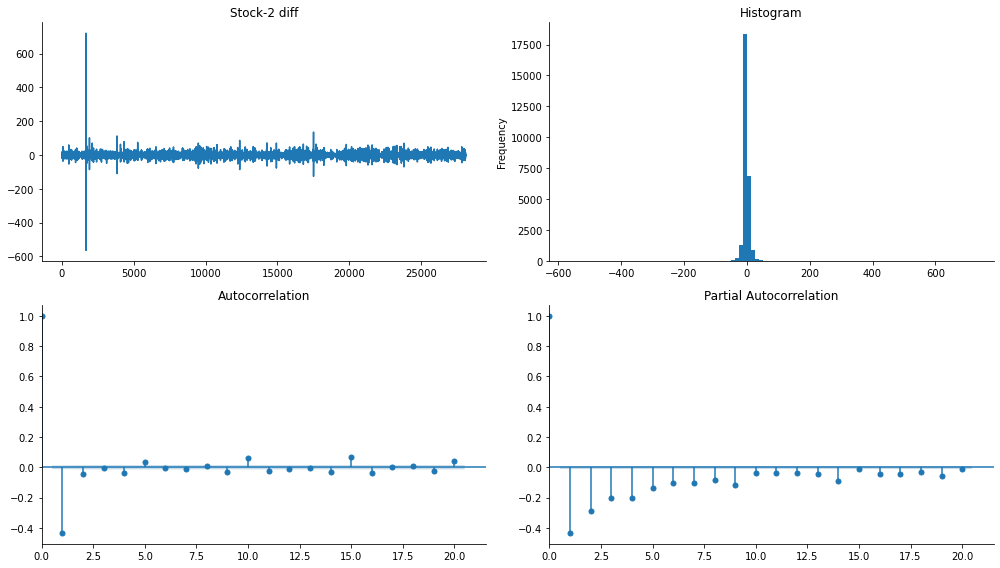

In [92]:
tsplot(stock_2["diff"], title='Stock-2 diff', lags=20)

(<AxesSubplot:title={'center':'Stock-3'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

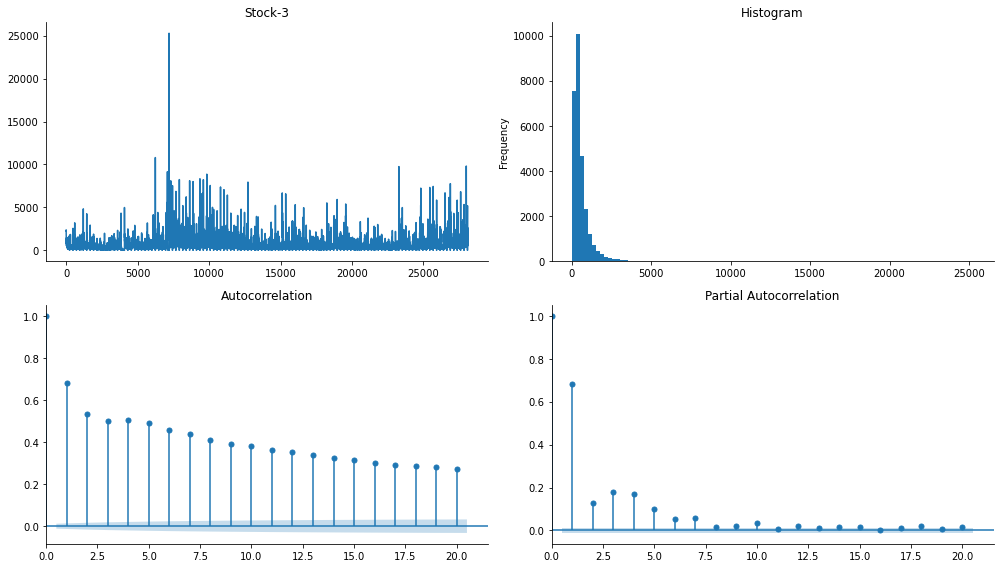

In [93]:
tsplot(stock_3["NumTrades"], title='Stock-3', lags=20)

(<AxesSubplot:title={'center':'Stock-3 diff'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

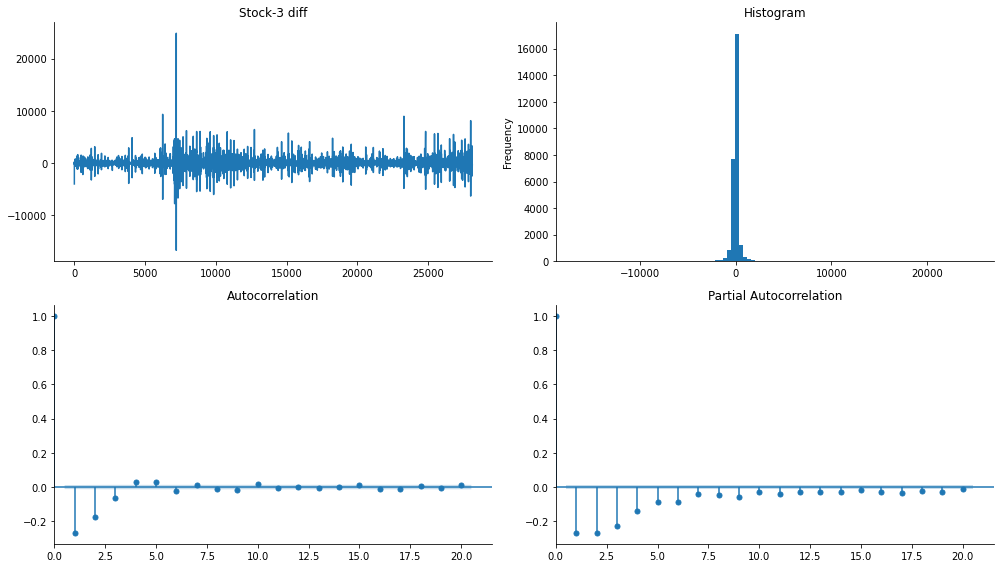

In [94]:
tsplot(stock_3["diff"], title='Stock-3 diff', lags=20)

(<AxesSubplot:title={'center':'Stock-4'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

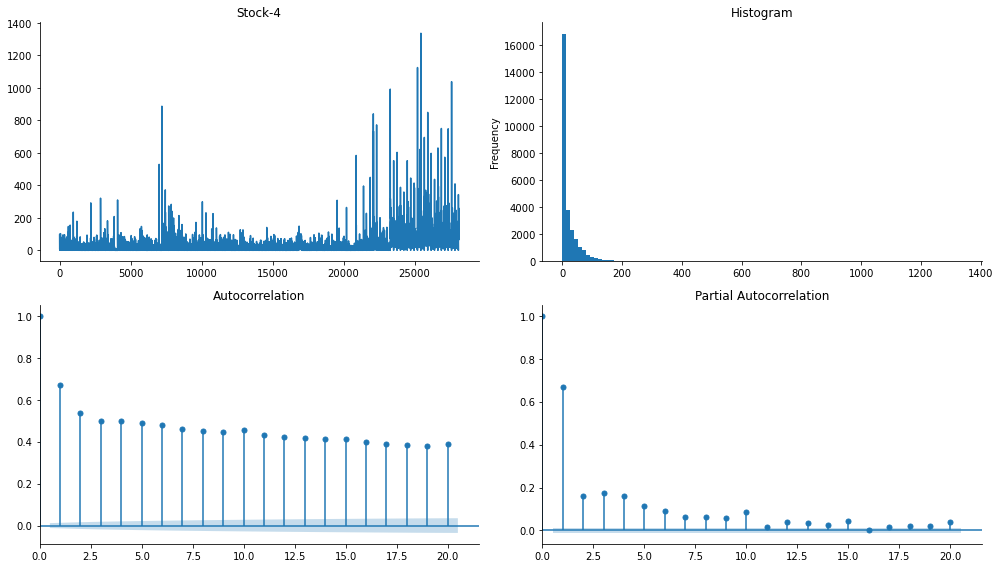

In [95]:
tsplot(stock_4["NumTrades"], title='Stock-4', lags=20)

(<AxesSubplot:title={'center':'Stock-4 diff'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

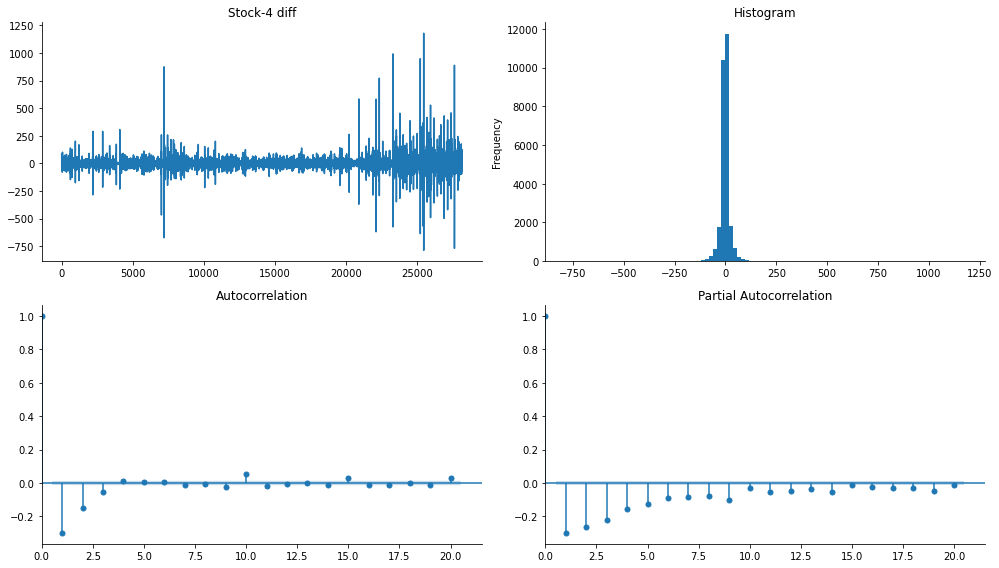

In [96]:
tsplot(stock_4["diff"], title='Stock-4 diff', lags=20)

AR和ARIMA的预测都非常接近于0,是由于差分后的序列均值为0，倾向于白噪声，这里没有很好的把趋势预测出来

这体现了Facebook Prophet的优势

In [155]:
'''
Use diff data: diff 
split sample into train and test data
'''
def AR_train(stock, string, p = 3):
    n_sample = stock.shape[0]
    #print(n_sample)
    n_train=int(0.99*n_sample)+1 #用99%的数据训练
    n_forecast=n_sample-n_train
    ts_train = stock['diff'][:n_train]
    ts_test = stock['diff'][n_train:]
    #print("training size: ",ts_train.shape)
    #print("testing size: ",ts_test.shape)
    print("Training Series:", "\n", ts_train.tail(), "\n")
    print("Testing Series:", "\n", ts_test.head())
    ar = AutoReg(ts_train, lags = p)
    ar_results = ar.fit()#fit模型
    #ar_results.summary()
    
    #2400min 代表未来10个交易日
    pred = ar_results.predict(n_train-1, n_sample+2400,dynamic=True)#预测，指定起始与终止时间。预测值起始时间必须在原始数据中，终止时间不需要
    #print ("Prediction from Autoregression: ")
    fig1 = plt.figure()
    plt.xlabel("Minutes of trading")
    plt.ylabel("NumTrades")
    plt.title(string+" AR predicted first-order change per minute")
    stock['diff'].plot()
    pred.plot()
    fig1.show()
    
    #return pred
    #AR还原一阶差分
    start = stock['NumTrades'][n_train-1]
    #print(start)
    restore = pred.cumsum() + start 
    fig2 = plt.figure()
    plt.xlabel("Minutes of trading")
    plt.ylabel("NumTrades")
    plt.title(string+" AR prediction restored per minute")
    
    stock['NumTrades'].plot()
    restore.plot()
    fig2.show()

stock_1对于训练量的讨论：

可以看到当使用所有数据时，预测值为负，当使用10天数据时，预测值为正且体现了均值。

Trick:或许有时较少的训练量可以得到合理的结果

Training Series: 
 27824     2.0
27825    13.0
27826    -2.0
27827     7.0
27828   -20.0
Name: diff, dtype: float64 

Testing Series: 
 27829     2.0
27830    18.0
27831    24.0
27832   -25.0
27833    -3.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show 

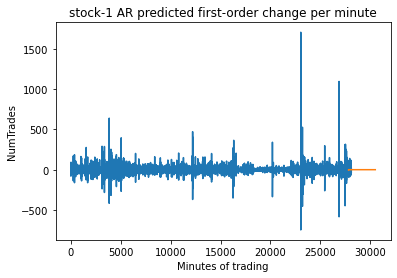

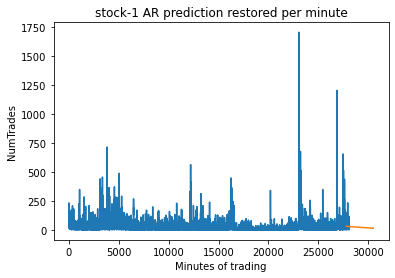

In [130]:
AR_train(stock_1, "stock-1", p = 2)

Training Series: 
 2372    30.0
2373   -10.0
2374     9.0
2375     1.0
2376     7.0
Name: diff, dtype: float64 

Testing Series: 
 2377   -32.0
2378    15.0
2379   -30.0
2380    30.0
2381    40.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


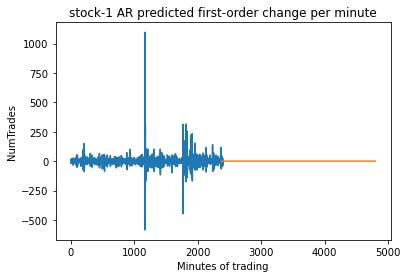

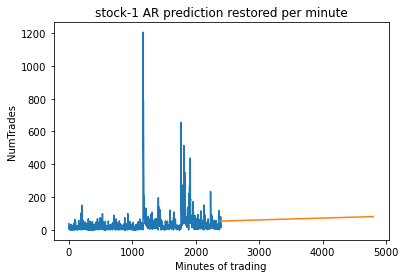

In [135]:
#只用10天的数据 2400min来预测
stock_1_ten_days = stock_1[-2400:]
stock_1_ten_days.index-=stock_1_ten_days.index[0]
#stock_1_ten_days
AR_train(stock_1_ten_days, "stock-1", p = 2)

Training Series: 
 27824   -1.0
27825    0.0
27826    0.0
27827    2.0
27828   -2.0
Name: diff, dtype: float64 

Testing Series: 
 27829     1.0
27830     6.0
27831    -6.0
27832     5.0
27833    12.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show 

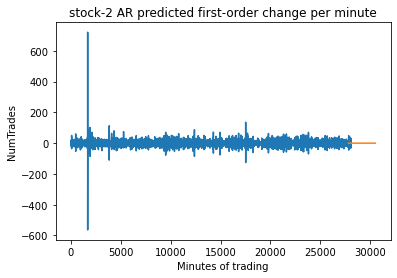

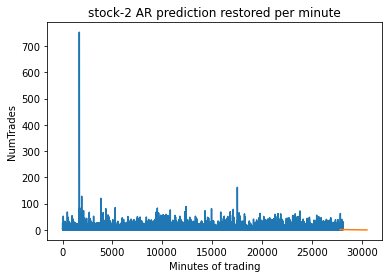

In [136]:
AR_train(stock_2, "stock-2", p = 2)

Training Series: 
 2372    -2.0
2373    11.0
2374   -11.0
2375     1.0
2376     6.0
Name: diff, dtype: float64 

Testing Series: 
 2377   -7.0
2378   -1.0
2379    0.0
2380    2.0
2381    0.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


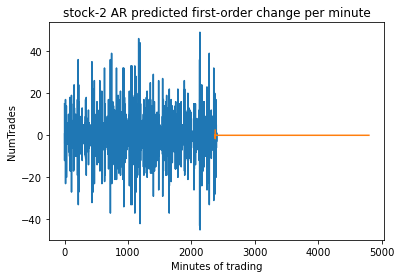

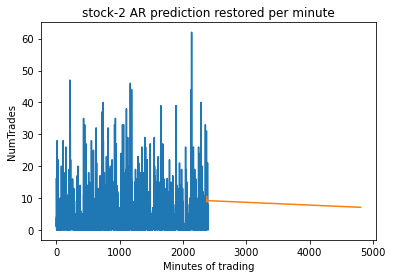

In [137]:
#只用10天的数据 2400min来预测
stock_2_ten_days = stock_2[-2400:]
stock_2_ten_days.index-=stock_2_ten_days.index[0]
AR_train(stock_2_ten_days, "stock-2", p = 2)

Training Series: 
 27824    108.0
27825     22.0
27826   -160.0
27827     83.0
27828    -99.0
Name: diff, dtype: float64 

Testing Series: 
 27829    177.0
27830    924.0
27831   -691.0
27832     95.0
27833      5.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show 

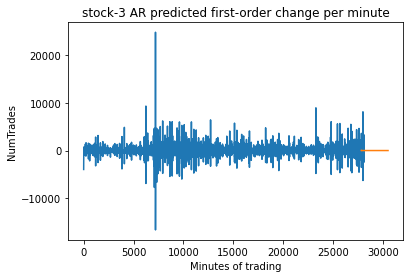

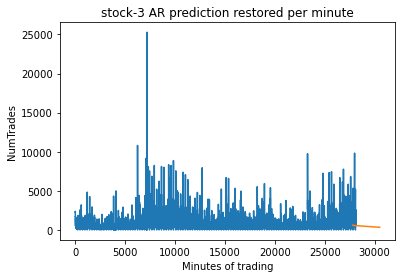

In [138]:
AR_train(stock_3, "stock-3", p = 2)

Training Series: 
 2372     99.0
2373   -198.0
2374   -866.0
2375    212.0
2376     46.0
Name: diff, dtype: float64 

Testing Series: 
 2377   -507.0
2378   -242.0
2379    -54.0
2380     16.0
2381   -279.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


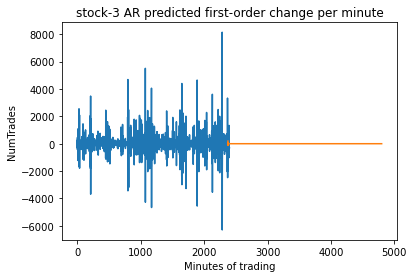

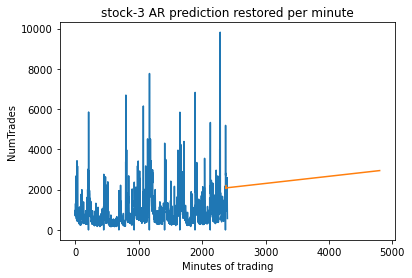

In [139]:
#只用10天的数据 2400min来预测
stock_3_ten_days = stock_3[-2400:]
stock_3_ten_days.index-=stock_3_ten_days.index[0]
AR_train(stock_3_ten_days, "stock-3", p = 2)

从stock_4的预测可以看到，AR模型捕捉到了短期相关性，预测到了均值的性质，stock_4的上涨趋势被捕捉到了。

Training Series: 
 27824   -27.0
27825    33.0
27826    56.0
27827    -8.0
27828   -55.0
Name: diff, dtype: float64 

Testing Series: 
 27829    23.0
27830   -16.0
27831     7.0
27832    42.0
27833   -39.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show 

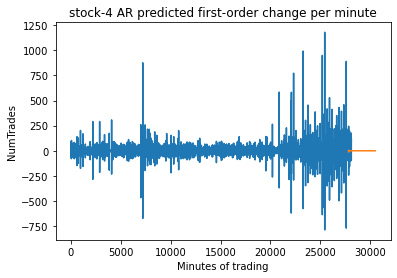

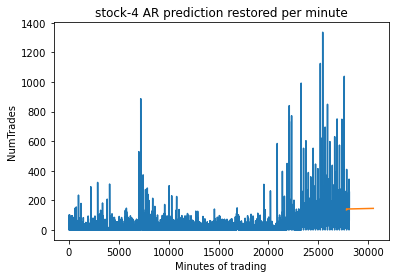

In [140]:
AR_train(stock_4, "stock-4", p = 2)

Training Series: 
 2372    -67.0
2373    -99.0
2374     17.0
2375    -39.0
2376    127.0
Name: diff, dtype: float64 

Testing Series: 
 2377   -96.0
2378     1.0
2379    21.0
2380    23.0
2381     2.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


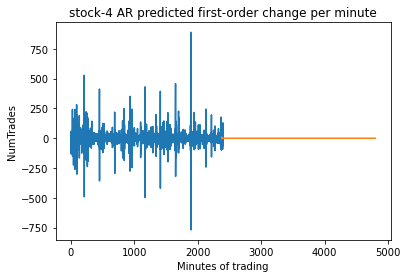

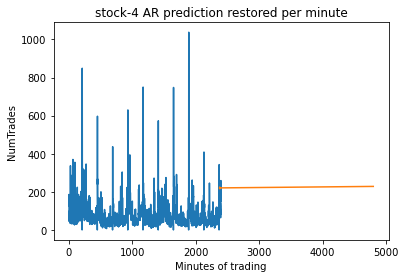

In [141]:
#只用10天的数据 2400min来预测
stock_4_ten_days = stock_4[-2400:]
stock_4_ten_days.index-=stock_4_ten_days.index[0]
AR_train(stock_4_ten_days, "stock-4", p = 2)

ARIMA模型的预测： 尝试了多组(p,d,q)的组合， 基本类似于AR，给出线性的预测； 有的预测甚至给出了负值，不可信

In [144]:
def ARIMA_train(stock, string, order = (1,0,1)):
    n_sample = stock.shape[0]
    #print(n_sample)
    n_train=int(0.9*n_sample)+1
    n_forecast=n_sample-n_train
    ts_train = stock['diff'][:n_train]
    ts_test = stock['diff'][n_train:]
    #print("training size: ",ts_train.shape)
    #print("testing size: ",ts_test.shape)
    print("Training Series:", "\n", ts_train.tail(), "\n")
    print("Testing Series:", "\n", ts_test.head())
    arima = ARIMA(ts_train, order=order)
    arima_results = arima.fit()#fit模型
    #ar_results.summary()
    
    pred = arima_results.predict(n_train-1, n_sample+2400,dynamic=True)#预测，指定起始与终止时间。预测值起始时间必须在原始数据中，终止时间不需要
    #print ("Prediction from Autoregression: ")
    fig1 = plt.figure()
    plt.title(string+" ARIMA predicted first-order change per minute")
    plt.xlabel("Minutes of trading")
    plt.ylabel("NumTrades")
    stock['diff'].plot()
    pred.plot()
    fig1.show()
    
    #return pred
    #AR还原一阶差分
    start = stock['NumTrades'][n_train-1]
    #print(start)
    restore = pred.cumsum() + start 
    fig2 = plt.figure()
    plt.title(string+" ARIMA prediction restored per minute")
    plt.xlabel("Minutes of trading")
    plt.ylabel("NumTrades")
    stock['NumTrades'].plot()
    restore.plot()
    fig2.show()

Training Series: 
 25295   -5.0
25296   -2.0
25297    8.0
25298   -6.0
25299    0.0
Name: diff, dtype: float64 

Testing Series: 
 25300   -1.0
25301   -2.0
25302    6.0
25303    3.0
25304   -2.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Use

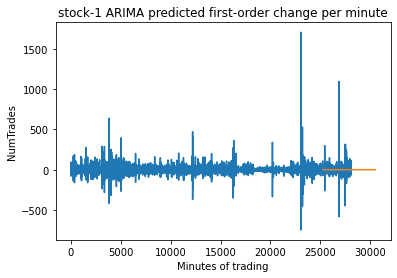

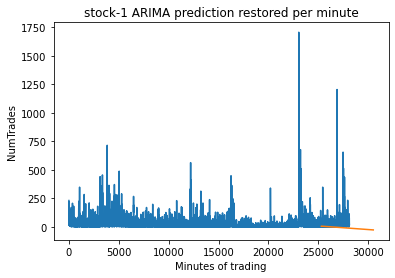

In [145]:
#stock-1, arima
ARIMA_train(stock_1, "stock-1", order = (1,0,1))

Training Series: 
 2156     7.0
2157    12.0
2158   -11.0
2159   -18.0
2160    16.0
Name: diff, dtype: float64 

Testing Series: 
 2161    -8.0
2162    13.0
2163   -10.0
2164    -6.0
2165   -15.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


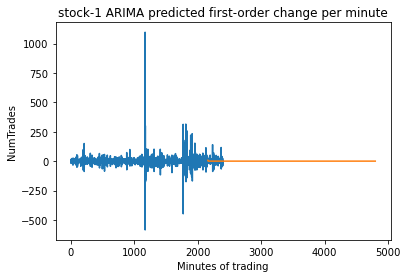

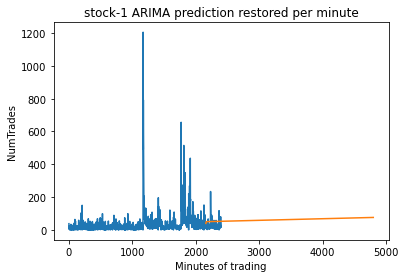

In [149]:
#只用10天的数据 2400min来预测
ARIMA_train(stock_1_ten_days, "stock-1", order = (1,0,1))

Training Series: 
 25295   -1.0
25296    0.0
25297    4.0
25298   -4.0
25299    2.0
Name: diff, dtype: float64 

Testing Series: 
 25300   -1.0
25301    1.0
25302   -2.0
25303    3.0
25304   -2.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Use

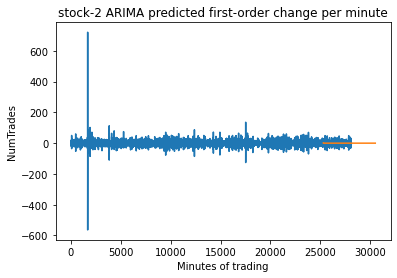

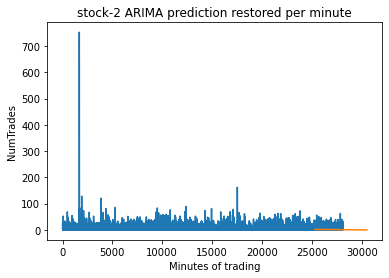

In [148]:
#stock-2, arima
ARIMA_train(stock_2, "stock-2", order = (1,0,1))

Training Series: 
 2156     6.0
2157     7.0
2158   -14.0
2159     1.0
2160     1.0
Name: diff, dtype: float64 

Testing Series: 
 2161    -3.0
2162     1.0
2163     1.0
2164    24.0
2165   -24.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


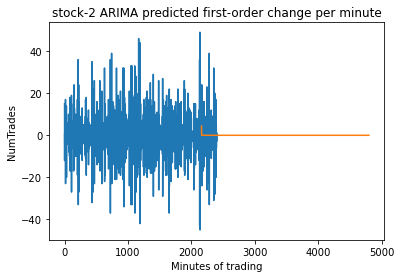

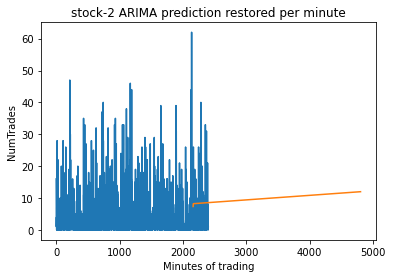

In [150]:
#只用10天的数据 2400min来预测
ARIMA_train(stock_2_ten_days, "stock-2", order = (1,0,1))

Training Series: 
 25295    -727.0
25296     120.0
25297    -560.0
25298     200.0
25299    1058.0
Name: diff, dtype: float64 

Testing Series: 
 25300    836.0
25301   -960.0
25302   -341.0
25303   -317.0
25304   -189.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Use

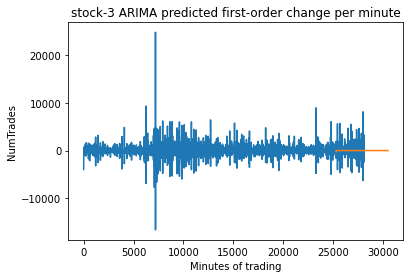

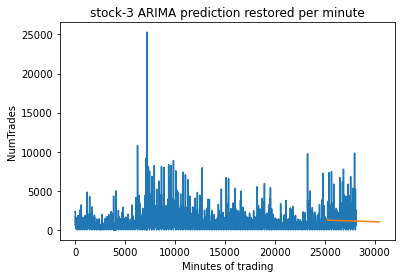

In [151]:
#stock-1, arima
ARIMA_train(stock_3, "stock-3", order = (1,0,1))

Training Series: 
 2156   -223.0
2157   -208.0
2158    133.0
2159   -194.0
2160   -182.0
Name: diff, dtype: float64 

Testing Series: 
 2161    138.0
2162   -192.0
2163    -41.0
2164    -34.0
2165    132.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


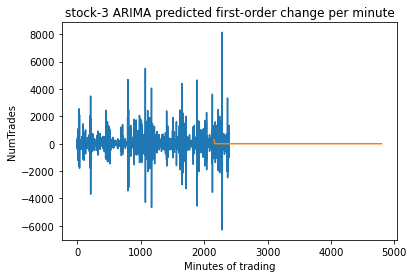

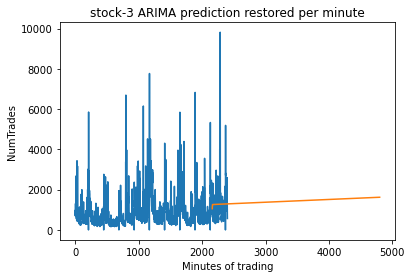

In [152]:
#只用10天的数据 2400min来预测
ARIMA_train(stock_3_ten_days, "stock-3", order = (1,0,1))

Training Series: 
 25295     8.0
25296   -11.0
25297    -6.0
25298    -2.0
25299    10.0
Name: diff, dtype: float64 

Testing Series: 
 25300    11.0
25301     2.0
25302   -12.0
25303    11.0
25304   -18.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Use

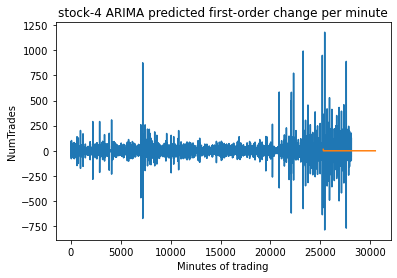

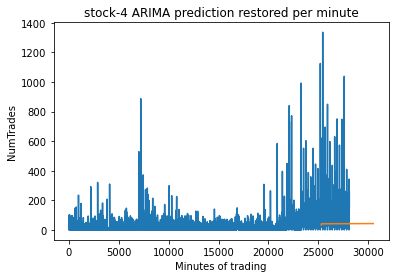

In [153]:
#stock-1, arima
ARIMA_train(stock_4, "stock-4", order = (1,0,1))

Training Series: 
 2156    -5.0
2157    25.0
2158   -19.0
2159   -28.0
2160    -1.0
Name: diff, dtype: float64 

Testing Series: 
 2161     3.0
2162    -3.0
2163    17.0
2164     1.0
2165     1.0
Name: diff, dtype: float64


C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Yuan Ji\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


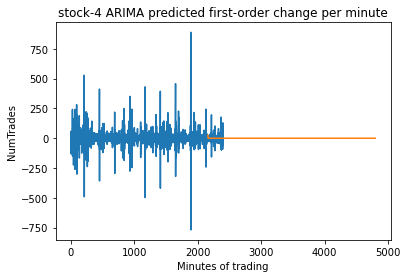

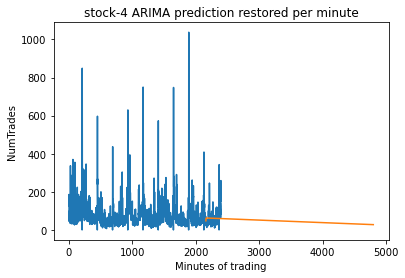

In [154]:
#只用10天的数据 2400min来预测
ARIMA_train(stock_4_ten_days, "stock-4", order = (1,0,1))